In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from scipy.optimize import minimize

#### Генерация набора данных

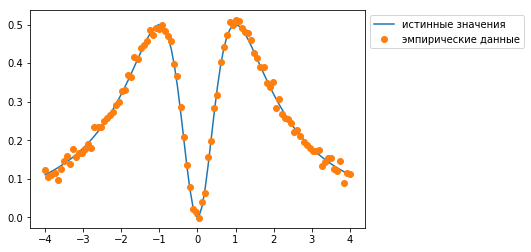

In [45]:
n = 100
x = np.linspace(-4, 4, n)

# Combination of three Gauss functions
y=2/(x**2+1)-2/(x**2+1)**2

y_true = y + 0.01*np.random.normal(0, 1, n)

plt.plot(x, y, '-',label='истинные значения');
plt.plot(x, y_true, 'o', label='эмпирические данные');
plt.legend(bbox_to_anchor=(1, 1))

### Разложение аппроксимирующей функции по радиальным базисным функциям

$y=\sum\limits_{i=1}^m{a_i\varphi_i(x)}\hspace{10mm}\varphi_i=(x^2+b_i^2)^{-d_i},\quad d_i>0$
  
Представим параметры $a, b, d$ в виде одного вектора $w$ как их последовательную конкатенацию
  
$y=\sum\limits_{i=1}^m{w_i\varphi_i(x)}\hspace{10mm}\varphi_i=(x^2+w_{i+m}^2)^{-|w_{i+2m}|}$

In [78]:
def basis_functions(w, x):
    basis = np.ndarray((len(x), m))
    for i in range(len(x)):
        basis[i]=(x[i]**2+w[m:m*2]**2)**(-np.abs(w[m*2:m*3]))
        
    return np.sum(basis*w[:m], axis=1)

#### Производные аппроксимирующей функции по параметрам

$\dfrac{\partial y}{\partial a_i}=(x^2+b_i^2)^{-d_i}$
  
$\dfrac{\partial y}{\partial b_i}=-2a_i b_i d_i (x^2+b_i^2)^{-d_i-1}$
  
$\dfrac{\partial y}{\partial d_i}=-a_i \ln(x^2+b_i^2) (x^2+b_i^2)^{-d_i} $

In [90]:
def basis_functions_deriv(w, x):
    deriv = np.zeros((3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            deriv[i] = (x**2+w[i+m]**2)**(-np.abs(w[i+2*m]))
        elif i < 2*m: # b
            deriv[i] = -2*w[i-m]*w[i]*np.abs(w[i+m])*(x**2+w[i]**2)**(-np.abs(w[i+m])-1)
        elif i < 3*m: # d
            deriv[i] = -w[i-2*m]*np.log(x**2+w[i-m]**2)*(x**2+w[i-m]**2)**(-np.abs(w[i]))
    
    return deriv

#### Вторые производные аппроксимирующей функции по параметрам

$\dfrac{\partial^2 y}{\partial a_i \partial a_j}=0\hspace{10mm}\forall{i,j}$
  
$\dfrac{\partial^2 y}{\partial a_i \partial b_j}=\dfrac{\partial^2 y}{\partial b_i \partial a_j}=-2b_i d_i (x^2+b_i^2)^{-d_i-1}\hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial a_i \partial d_j}=\dfrac{\partial^2 y}{\partial d_i \partial a_j}=(x^2+b_i^2)^{-d_i}\ln(x^2+b_i^2)\hspace{10mm}i=j$
  
---------
$\dfrac{\partial^2 y}{\partial b_i \partial b_j}=-2a_i d_i (x^2-b_i^2 (2d_i+1)) (x^2+b_i^2)^{-d_i-2} \hspace{10mm}i=j$
  
$\dfrac{\partial^2 y}{\partial b_i \partial d_j}=\dfrac{\partial^2 y}{\partial d_i \partial b_j}=2a_i b_i (d_i \ln (x^2+b_i^2)-1)(x^2+b_i^2)^{-d_i-1}\hspace{10mm}i=j$
  
---------
  
$\dfrac{\partial^2 y}{\partial d_i \partial d_j}=a_i (x^2+b_i^2)^{-d_i} \ln^2(x^2+b_i^2)\hspace{10mm}i=j$

In [81]:
def basis_functions_hess(w, x):
    hess = np.zeros((3*m, 3*m, len(x)))
    for i in range(3*m):
        if i < m: # a
            a = w[i]
            b = w[i+m]
            d = np.abs(w[i+2*m])# d>0
            hess[i, i+m] = -2*b*d*(x**2+b**2)**(-d-1)
            hess[i, i+2*m] = (x**2+b**2)**(-d)*np.log(x**2+b**2)
            
        elif i < 2*m: # b
            a = w[i-m]
            b = w[i]
            d = np.abs(w[i+m])# d>0

            hess[i, i-m] = hess[i-m,i]
            hess[i, i] = 2*a*d*(x**2-b**2*(2*d+1))*(x**2+b**2)**(-d-2)
            hess[i, i+m] = 2*a*b*(d*np.log(x**2+b**2)-1)*(x**2+b**2)**(-d-1)
            
        elif i < 3*m: # d
            a = w[i-2*m]
            b = w[i-m]
            d = np.abs(w[i])#d>0
            expon = np.exp(-((x - b) / d)**2)
            hess[i, i-2*m] =hess [i-2*m,i]
            hess[i, i-m] = hess[i-m,i]
            hess[i, i] = a*(x**2+b**2)**(-d)*np.log(x**2+b**2)**2
    
    return hess

#### Функция ошибки аппроксимации

$error = \sum\limits_{i=1}^n{\left(y_i-y_{true_i}\right)^2}$

In [48]:
def error_func(w):
    basis = basis_functions(w, x)
    error = 0
    for i in range(len(y_true)):
        error += (basis[i] - y_true[i])**2
    return error

#### Градиент целевой функции 

$\dfrac{\partial error}{\partial w_j} = 2\sum\limits_{i=1}^n{\dfrac{\partial y_i}{\partial w_j}\left(y_i-y_{true_i}\right)}$

In [49]:
def error_func_deriv(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    error_deriv = np.zeros(3*m)
    for i in range(3*m):
        error_deriv[i] = 2*np.sum((basis - y_true)*basis_deriv[i], axis=0)
    return error_deriv

#### Матрица Гессе целевой функции 

$\dfrac{\partial error}{\partial w_j \partial w_k} = 2\sum\limits_{i=1}^n{\left(\dfrac{\partial y_i}{\partial w_j}\dfrac{\partial y_i}{\partial w_k} + \dfrac{\partial^2 y_i}{\partial w_j \partial w_k}\left(y_i-y_{true_i}\right)\right)}$

In [50]:
def error_func_hess(w):
    basis = basis_functions(w, x)
    basis_deriv = basis_functions_deriv(w, x)
    basis_hess = basis_functions_hess(w, x)
    error_hess = np.zeros((3*m, 3*m))
    for i in range(3*m):
        for j in range(3*m):
            error_hess[i,j] = 2*np.sum((basis_deriv[i]*basis_deriv[j] + basis_hess[i,j]*(basis - y_true)), axis=0)
    return error_hess

#### Задание начального приближения

In [94]:
m = 2 # number of basis functions
a = np.random.normal(loc=0,scale=1,size=m)
#a=[2.,-2.]
b = np.random.normal(loc=0,scale=1,size=m)
#b=[1,1]
d = np.abs(np.random.normal(loc=0,scale=1,size=m))
#d=[1,2]
w = np.concatenate((a,b,d))
np.set_printoptions(precision=3, suppress=True)
print('Начальные параметры')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(w[i], w[i+m], w[i+2*m]))

Начальные параметры
a:   0.903   b:   0.757   d:   0.440
a:  -1.153   b:   0.946   d:   0.998


Начальная ошибка: 4.225976861365774


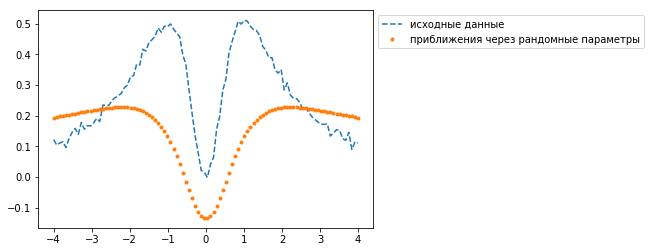

In [95]:
plt.plot(x, y_true, '--',label='исходные данные')
plt.plot(x, basis_functions(w, x), '.', label='приближения через рандомные параметры')
plt.legend(bbox_to_anchor=(1, 1))
print('Начальная ошибка:', error_func(w))

### Симплекс-метод Нелдера-Мида (Nelder-Mead)

#### Минимизация методом 0-го порядка

Optimization terminated successfully.
         Current function value: 0.013484
         Iterations: 1056
         Function evaluations: 1619

Параметры аппроксимирующей функции после оптимизации
a:   2.310   b:   1.002   d:   1.048
a:  -2.235   b:   0.992   d:   1.897
Ошибка после минимизации: 0.013483920269621502
CPU times: user 1.32 s, sys: 13.1 ms, total: 1.33 s
Wall time: 1.41 s


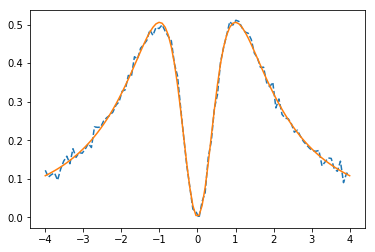

In [96]:
%%time
res = minimize(error_func, w, method='Nelder-Mead',options={'maxiter':10000,'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

### Алгоритм Бройдена-Флетчера-Голдфарба-Шанно (BFGS)

#### Минимизация методом 1-го порядка

Optimization terminated successfully.
         Current function value: 0.013460
         Iterations: 1025
         Function evaluations: 1215
         Gradient evaluations: 1215

Параметры аппроксимирующей функции после оптимизации
a:   2.311   b:   1.433   d:   1.056
a:  -1.009   b:   0.986   d:   2.344
Ошибка после минимизации: 0.01346029238373509
CPU times: user 2.19 s, sys: 18.3 ms, total: 2.21 s
Wall time: 2.37 s


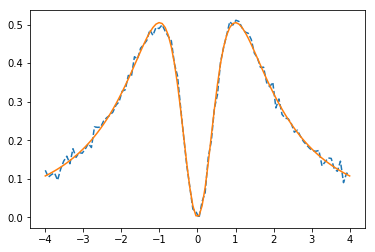

In [97]:
%%time
res = minimize(error_func, w, method='BFGS', jac=error_func_deriv, options={'maxiter':10000, 'disp': True})
#res = minimize(error_func, w, method='BFGS', options={'maxiter':10000, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));

#### Метод Пауэлла

Optimization terminated successfully.
         Current function value: 0.013502
         Iterations: 27
         Function evaluations: 2825

Параметры аппроксимирующей функции после оптимизации
a:   2.262   b:   0.868   d:   1.043
a:  -2.702   b:   0.970   d:   1.926
Ошибка после минимизации: 0.013501872205763788


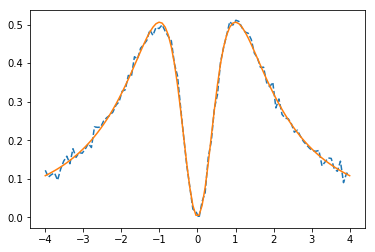

In [100]:
res = minimize(error_func, w, method='powell',
    options={'maxiter':10000,'xtol': 1e-8, 'disp': True})
print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
plt.plot(x, basis_functions(res.x, x));

### Алгоритм сопряженных градиентов (Ньютона)

Optimization terminated successfully.
         Current function value: 0.013460
         Iterations: 1170
         Function evaluations: 1206
         Gradient evaluations: 2375
         Hessian evaluations: 1170

Параметры аппроксимирующей функции после оптимизации
a:   2.310   b:   1.432   d:   1.056
a:  -1.009   b:   0.985   d:   2.341
Ошибка после минимизации: 0.013460292464691005


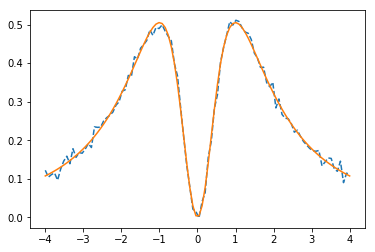

In [103]:
res = minimize(error_func, w, method='Newton-CG', 
               jac=error_func_deriv, hess=error_func_hess,
               options={'xtol': 1e-8, 'disp': True})

print('\nПараметры аппроксимирующей функции после оптимизации')
for i in range(m):
    print('a:{:>8.3f}   b:{:>8.3f}   d:{:>8.3f}'.format(res.x[i], res.x[i+m], res.x[i+2*m]))
print('Ошибка после минимизации:', res.fun)
plt.plot(x, y_true, '--')
#plt.plot(x, basis_functions(w, x), '.')
plt.plot(x, basis_functions(res.x, x));